# Wavelet CNN

## Imports

In [1]:
import os
import optuna
import time
import spectral
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from torchmetrics.classification import MulticlassConfusionMatrix
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.decomposition import PCA
from pytorch_wavelets import DWTForward
from tqdm import tqdm
import random
from torchviz import make_dot
import h5py
import gc
import matplotlib.patches as mpatches

from torch.utils.data import ConcatDataset
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

start_time = time.time() 

c:\Users\Philip Shahdadfar\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Is CUDA available?:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available.")

print("Allocated GPU memory:", torch.cuda.memory_allocated())
print("Cached GPU memory:", torch.cuda.memory_reserved())


DEVICE = 0

Is CUDA available?: True
Current CUDA device: 0
Device name: NVIDIA GeForce RTX 3080 Ti
Allocated GPU memory: 0
Cached GPU memory: 0


## Settings

In [3]:
DATASET = 'SLC'    

if DATASET == 'Sal':
    N_PCA = 170
    TRAIN_SIZE = 0.2990 
    EPOCH = 82    
    BATCH_SIZE = 32
    PATCH_SIZE = 13 
    LR = 0.000269    
    WEIGHT_DECAY = 0.0001616  

elif DATASET == 'SalA':
    N_PCA = 150
    TRAIN_SIZE = 0.2721    
    EPOCH = 55    
    BATCH_SIZE = 32
    PATCH_SIZE = 31 
    LR = 0.006597    
    WEIGHT_DECAY = 1e-6 

elif DATASET == 'Indian Pines':
    N_PCA = 190
    TRAIN_SIZE = 0.2755    
    EPOCH = 30    
    BATCH_SIZE = 32
    PATCH_SIZE = 19 
    LR = 0.00726738    
    WEIGHT_DECAY = 0.000640487  
    
elif DATASET == 'PaviaU':
    N_PCA = 103
    TRAIN_SIZE = 0.2892    
    EPOCH = 77    
    BATCH_SIZE = 64
    PATCH_SIZE = 9 
    LR = 0.0005042    
    WEIGHT_DECAY = 0.0001894

elif DATASET == 'SLC':
    TRAIN_SIZE = 0.9
    BATCH_SIZE = 32
    EPOCH = 10
    PATCH_SIZE = 64 
    LR = 0.001   
    WEIGHT_DECAY = 1e-6 
    
else:
    N_PCA = 190
    
ALL_BANDS = False
VAL_EPOCH = 5
VAL_RATE = 0.1    
RANDOM_SEED=42

#print(f'Number of bands utilized: {N_PCA}') 
print(f'Training size: {TRAIN_SIZE}') 
print(f'Epochs: {EPOCH}') 
print(f'Batch size: {BATCH_SIZE}') 
print(f'Patch size: {PATCH_SIZE}') 
print(f'Learning rate: {LR}') 
print(f'Weight decay: {WEIGHT_DECAY}') 

Training size: 0.9
Epochs: 10
Batch size: 32
Patch size: 64
Learning rate: 0.001
Weight decay: 1e-06


In [4]:
## Set random seed for reproduction
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



SAVE_PATH = f"results\\{DATASET}"
if not os.path.isdir(SAVE_PATH):
    os.mkdir(SAVE_PATH)

## Dataset

In [5]:

def applyPCA(X, numComponents):
    """
    Apply PCA on a single image.
    """
    newX = np.reshape(X, (-1, X.shape[2]))  # Flatten spatial dimensions
    pca = PCA(n_components=numComponents, whiten=True)  # PCA with normalization
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))  # Reshape back
    return newX, pca

def load_dataset(dataset_name, ignore_scenes=None, selected_bands=None, apply_pca=False, num_pca_components=10, selected_features=None):
  
    if ignore_scenes is None:
        ignore_scenes = []  
    
    datapath = os.path.join(os.getcwd(), 'Datasets')
    
    if dataset_name == 'SLC':
        dataset_path = os.path.join(datapath, 'SLC')
        
        data_files = [f for f in os.listdir(dataset_path) if f.endswith('.mat')]
        label_files = [f for f in os.listdir(dataset_path) if f.endswith('_class_NPY_FORMAT.npy')]
        
        data_scenes = {os.path.splitext(f)[0]: f for f in data_files}
        label_scenes = {f.replace('_class_NPY_FORMAT.npy', ''): f for f in label_files}
        
        #common_scenes = sorted(set(data_scenes.keys()) & set(label_scenes.keys()))
        common_scenes = sorted(set(data_scenes.keys()) & set(label_scenes.keys()))[:10]  # Take only the first 10 images

        common_scenes = [scene for scene in common_scenes if scene not in ignore_scenes]
        
        data_list = []
        label_list = []
        class_name = ["Sea", "Land", "Cloud"]
        
        for scene in common_scenes:
            data_path = os.path.join(dataset_path, data_scenes[scene])
            label_path = os.path.join(dataset_path, label_scenes[scene])
            
            mat_contents = sio.loadmat(data_path)
            available_keys = [key for key in mat_contents.keys() if not key.startswith('__')]
            
            if scene in mat_contents:
                data = mat_contents[scene]
            elif len(available_keys) == 1:
                data = mat_contents[available_keys[0]]
            else:
                raise KeyError(f"Key '{scene}' not found in {data_path}. Available keys: {available_keys}")
            
            # Select first `selected_bands` spectral bands
            if isinstance(selected_bands, int):
                data = data[:, :, :selected_bands]  # Keep only the first `N` bands
            
            data_list.append(data)
            label_list.append(np.load(label_path))
        
        data_list = np.array(data_list)
        label_list = np.array(label_list)

        if apply_pca:
            print(f"Total images to process: {len(data_list)}")
            pca_transformed_list = []
            pca_models = []  

            with tqdm(total=len(data_list), desc="Applying PCA") as pbar:
                for i in range(len(data_list)):
                    data, pca = applyPCA(data_list[i], num_pca_components)  
                    pca_transformed_list.append(data)  
                    pca_models.append(pca)  
                    pbar.update(1)  

            data_list = np.array(pca_transformed_list)
            print("PCA processing completed, moving to feature selection...")

            if selected_features is not None:
                print(f"Before filtering: {len(selected_features)} selected features.")
                print(f"Selected feature indices: {selected_features}")
                print(f"Max valid feature index: {num_pca_components-1}")

    # Ensure all selected features are within bounds
            valid_features = [f for f in selected_features if f < num_pca_components]

            print(f"After filtering: {len(valid_features)} valid features.")


    
                

        print("Returning processed dataset...")
        return data_list, label_list, class_name, common_scenes

    else:
        raise ValueError(f"Dataset {dataset_name} not recognized.")


# -------------------- PARAMETERS --------------------
ignore_scenes = ["Niger_2022_09_06T09_26_29", "griegFinnmark_2022_07_06", "erie_2022-09-21", "palliserIslands_2022-10-22"]

selected_bands = 72
selected_features = [78,  77,  79,  72,  73,  64,  74,  66,  67,  68,  75,  65,  69,  71,  76,  63,  80,  81,
  70,  84,  85,  82,  83,  86,  93,  39,  91,  40,  38,  92,  41,  94,  90,  89,  62,  37,
  87, 88,  36,  95,  35,  16,  43,  46,  42,  96,  47,  44,  17,  45,  48,  97,  61,  98,
  49,  57,  15,  50,  58,  99,  51,  56,  14,  60, 100,  59,  55,  52,  18,  34,  53,  54,
 101, 102,  28,  27,  26,  30,  19,  31,  13,  29, 103,  32, 104,  20,   8,   9,  33,  25,
   7, 105,   6, 106,  23,  21,  22,  24,  10, 107, 109, 108,
 110, 111, 112,  12, 113,  11, 114, 115, 116]  

apply_pca = True
num_pca_components = selected_bands
print(num_pca_components)

# -------------------- EXECUTE --------------------

data_list, label_list, class_name, common_scenes = load_dataset("SLC", 
                                                                selected_bands=selected_bands, 
                                                                apply_pca=apply_pca, 
                                                                num_pca_components=num_pca_components, 
                                                                selected_features=selected_features)

print(f"Number of images: {len(data_list)}")
print(f"Data Shape: {data_list.shape}")  
print(f"Labels Shape: {label_list.shape}")  

72
Total images to process: 10


Applying PCA: 100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


PCA processing completed, moving to feature selection...
Before filtering: 111 selected features.
Selected feature indices: [78, 77, 79, 72, 73, 64, 74, 66, 67, 68, 75, 65, 69, 71, 76, 63, 80, 81, 70, 84, 85, 82, 83, 86, 93, 39, 91, 40, 38, 92, 41, 94, 90, 89, 62, 37, 87, 88, 36, 95, 35, 16, 43, 46, 42, 96, 47, 44, 17, 45, 48, 97, 61, 98, 49, 57, 15, 50, 58, 99, 51, 56, 14, 60, 100, 59, 55, 52, 18, 34, 53, 54, 101, 102, 28, 27, 26, 30, 19, 31, 13, 29, 103, 32, 104, 20, 8, 9, 33, 25, 7, 105, 6, 106, 23, 21, 22, 24, 10, 107, 109, 108, 110, 111, 112, 12, 113, 11, 114, 115, 116]
Max valid feature index: 71
After filtering: 66 valid features.
Returning processed dataset...
Number of images: 10
Data Shape: (10, 956, 684, 72)
Labels Shape: (10, 956, 684)


## Pre-process data

### Create image patches

In [6]:
class PatchSet(Dataset):
    """ Generate 3D patch from hyperspectral dataset """
    def __init__(self, data, gt, patch_size, is_pred=False):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the 3D patch
            is_pred: bool, create data without label for prediction (default False) 

        """
        super(PatchSet, self).__init__()
        self.is_pred = is_pred
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data,((p,p),(p,p),(0,0)),'constant',constant_values = 0)
        if is_pred:
            gt = np.ones_like(gt)
        self.label = np.pad(gt,(p,p),'constant',constant_values = 0)
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p   ##indices after padding
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        if not is_pred:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
        if self.is_pred:
            return data
        else: return data, label

## Print 

### Display HSI

In [7]:
# class_names = {0: "Water", 1: "Land", 2: "Clouds"}  # Modify as needed

# for data, label, scene in zip(data_list, label_list, common_scenes):
#     fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 

#     rgb_data_1 = spectral.get_rgb(data, (29, 20, 10))  
#     rgb_data_2 = spectral.get_rgb(data, (0, 10, 20)) 

#     axes[0].imshow(rgb_data_1)
#     axes[0].set_title(f'RGB Origin - {scene}')
#     axes[0].axis('off')

#     # GroundTruth with color legend
#     im = axes[1].imshow(label, cmap='jet')
#     axes[1].set_title(f'GroundTruth - {scene}')
#     axes[1].axis('off')

#     axes[2].imshow(rgb_data_2)
#     axes[2].imshow(label, cmap='jet', alpha=0.5)
#     axes[2].set_title(f'Overlay - {scene}')
#     axes[2].axis('off')

#     # Extract unique labels present in the current label image
#     unique_labels = np.unique(label)

#     # Create legend with corresponding colors
#     patches = [
#         mpatches.Patch(color=plt.cm.jet(label_val / max(unique_labels)), label=class_names.get(label_val, f"Class {label_val}"))
#         for label_val in unique_labels
#     ]
    
#     # Add legend below GroundTruth
#     legend = axes[1].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)
    
#     plt.suptitle(f'Scene: {scene}', fontsize=14, fontweight='bold')
    
#     plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
#     plt.show()

## Apply Transformations

### Data Split

In [8]:
# -------------------- SPLIT IMAGES INTO TRAIN / VAL / TEST --------------------
image_indices = np.arange(len(data_list))  # Indices of images
train_indices, temp_indices = train_test_split(image_indices, test_size=0.20, random_state=42)  
val_indices, test_indices = train_test_split(temp_indices, test_size=0.50, random_state=42)  
print(f"Training images: {len(train_indices)} | Validation images: {len(val_indices)} | Test images: {len(test_indices)}")

Training images: 8 | Validation images: 1 | Test images: 1


In [9]:
# -------------------- CREATE PATCHED DATASETS --------------------
PATCH_SIZE = 8  # Set patch size
BATCH_SIZE = 512  # Set batch size

# Create training dataset from training images
train_patches = [PatchSet(data_list[i], label_list[i], PATCH_SIZE) for i in train_indices]
train_dataset = torch.utils.data.ConcatDataset(train_patches)

# Create validation dataset from validation images
val_patches = [PatchSet(data_list[i], label_list[i], PATCH_SIZE) for i in val_indices]
val_dataset = torch.utils.data.ConcatDataset(val_patches)

# Create test dataset from test images
test_patches = [PatchSet(data_list[i], label_list[i], PATCH_SIZE, is_pred=True) for i in test_indices]
test_dataset = torch.utils.data.ConcatDataset(test_patches)

## Create dataset and dataloader

In [10]:

# -------------------- CREATE DATALOADERS --------------------
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)
print(f"Train patches: {len(train_dataset)} | Val patches: {len(val_dataset)} | Test patches: {len(test_dataset)}")

class_nums = 3

Train patches: 3451094 | Val patches: 384196 | Test patches: 653904


## Model

In [11]:
class WaveletCNN(nn.Module):
    def __init__(self, in_channels, class_nums, levels=4, base_channels=8):
        super(WaveletCNN, self).__init__()
        self.levels = levels
        self.base_channels = base_channels

        # Wavelet transform
        self.dwt = nn.ModuleList([DWTForward(J=1, mode='zero', wave='db1') for _ in range(levels)])
        self.projections = nn.ModuleList()
        self.conv_blocks = nn.ModuleList()

        for i in range(levels):
            prev_channels = sum(base_channels * (2 ** j) for j in range(i))
            input_channels = in_channels + 3 * in_channels + prev_channels
            output_channels = base_channels * (2 ** i)
            
            self.projections.append(nn.Conv2d(input_channels, output_channels, kernel_size=1))
            self.conv_blocks.append(nn.Sequential(
                nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            ))

        total_channels = sum(base_channels * (2 ** i) for i in range(levels))

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(total_channels, class_nums)

    def forward(self, x):
        features = []
        low_pass = x

        for i in range(self.levels):
          
            low_pass, high_pass = self.dwt[i](low_pass)
            batch_size, channels, height, width = low_pass.shape
            _, high_pass_channels, subbands, _, _ = high_pass[0].shape

           
            high_pass = high_pass[0].view(batch_size, high_pass_channels * subbands, height, width)

        
            resized_features = [
                F.interpolate(feat, size=(height, width), mode='bilinear', align_corners=False)
                for feat in features
            ]

            concatenated = torch.cat([low_pass, high_pass] + resized_features, dim=1)
 
           
            projected = self.projections[i](concatenated)
            conv_out = self.conv_blocks[i](projected)
           
            
            features.append(conv_out)

       
        smallest_height, smallest_width = features[-1].shape[2:]
        resized_features = [
            F.interpolate(feat, size=(smallest_height, smallest_width), mode='bilinear', align_corners=False)
            for feat in features
        ]

        out = torch.cat(resized_features, dim=1)
        out = self.global_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


In [12]:
# Initialize the model
in_channels = data_list.shape[-1]
print(in_channels)
net = WaveletCNN(in_channels=in_channels, class_nums=3)

# Input tensor
input_tensor = torch.randn(1, data_list.shape[-1], PATCH_SIZE, PATCH_SIZE)
print(f"Input tensor shape: {input_tensor.shape}")

# Model summary
summary(
    net,
    input_size=(1, data_list.shape[-1], PATCH_SIZE, PATCH_SIZE),
    col_names=['num_params', 'kernel_size', 'mult_adds', 'input_size', 'output_size'],
    col_width=18,
    row_settings=['var_names'],
    depth=4,
)

72
Input tensor shape: torch.Size([1, 72, 8, 8])


Layer (type (var_name))                  Param #            Kernel Shape       Mult-Adds          Input Shape        Output Shape
WaveletCNN (WaveletCNN)                  --                 --                 --                 [1, 72, 8, 8]      [1, 3]
├─ModuleList (dwt)                       --                 --                 --                 --                 --
│    └─DWTForward (0)                    --                 --                 --                 [1, 72, 8, 8]      [1, 72, 4, 4]
├─ModuleList (projections)               (recursive)        --                 --                 --                 --
│    └─Conv2d (0)                        2,312              [1, 1]             36,992             [1, 288, 4, 4]     [1, 8, 4, 4]
├─ModuleList (conv_blocks)               (recursive)        --                 --                 --                 --
│    └─Sequential (0)                    --                 --                 --                 [1, 8, 4, 4]       [1, 8, 4

## Training

Validation Progress: 100%|██████████| 751/751 [00:15<00:00, 49.10it/s]


Training completed in 1503.52 seconds.
Stopped at epoch 9


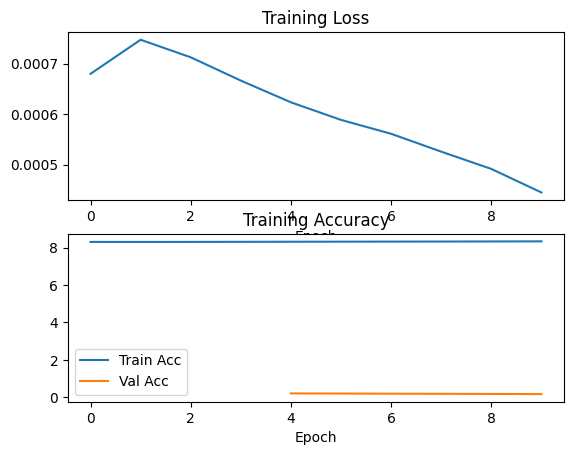

In [20]:
from tqdm import tqdm
import torch

## Training the model
device = torch.device(DEVICE if DEVICE >= 0 and torch.cuda.is_available() else 'cpu')
loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []

model = WaveletCNN(data_list.shape[-1], class_nums=3)  # Use one model for all images
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), LR, weight_decay=WEIGHT_DECAY)
loss_func = nn.CrossEntropyLoss()

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

e = -1
start_time = time.time()

# Compute the total number of validation patches
val_num = sum(len(PatchSet(data_list[i], label_list[i], PATCH_SIZE)) for i in val_indices)

try:
    for e in range(EPOCH):  # Train across all images for multiple epochs
        model.train()
        avg_loss = 0.
        train_acc = 0

        # Iterate over all training images in one epoch
        for img_idx in range(len(train_indices)):
            train_patches = PatchSet(data_list[train_indices[img_idx]], label_list[train_indices[img_idx]], PATCH_SIZE)
            train_loader = DataLoader(train_patches, BATCH_SIZE, shuffle=True)

            with tqdm(total=len(train_loader), desc=f"Epoch {e+1}/{EPOCH} - Training Image {img_idx+1}/{len(train_indices)}", leave=True) as batch_pbar:
                for batch_idx, (data, target) in enumerate(train_loader):
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    out = model(data)
                    target = target - 1  ## class 0 in out is class 1 in target
                    loss = loss_func(out, target)
                    loss.backward()
                    optimizer.step()
                    avg_loss += loss.item()
                    _, pred = torch.max(out, dim=1)
                    train_acc += (pred == target).sum().item()

                    # Update batch progress bar
                    batch_pbar.update(1)

        loss_list.append(avg_loss / len(train_loader.dataset))
        acc_list.append(train_acc / len(train_loader.dataset))

        ## Validation
        if (e + 1) % VAL_EPOCH == 0 or (e + 1) == EPOCH:
            val_acc = 0
            model.eval()
            with tqdm(total=len(val_loader), desc="Validation Progress", leave=True) as val_pbar:
                for batch_idx, (data, target) in enumerate(val_loader):
                    data, target = data.to(device), target.to(device)
                    out = model(data)
                    target = target - 1  ## class 0 in out is class 1 in target
                    _, pred = torch.max(out, dim=1)
                    val_acc += (pred == target).sum().item()

                    # Update validation progress bar
                    val_pbar.update(1)

            val_acc_list.append(val_acc / val_num)
            val_epoch_list.append(e)
            save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
            torch.save(model.state_dict(), save_name)

    ax1.plot(np.arange(e + 1), loss_list)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax2.plot(np.arange(e + 1), acc_list, label='Train Acc')
    ax2.plot(val_epoch_list, val_acc_list, label='Val Acc')
    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()

except Exception as exc:
    print(exc)
finally:
    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds.")
    print(f'Stopped at epoch {e}')


## Save/Load Model

### Load

In [ ]:
## Load the best model after training
best_model_path = get_best_model(val_acc_list, val_epoch_list, SAVE_PATH)
best_model = WaveletCNN(data_list.shape[-1], class_nums=3)
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)
best_model.eval()

## Perform inference per testing image
for img_idx in range(len(test_indices)):  
    print(f"\nPerforming inference on Test Image {img_idx+1}/{len(test_indices)}...")

    test_patches = PatchSet(data_list[test_indices[img_idx]], label_list[test_indices[img_idx]], PATCH_SIZE, is_pred=True)
    test_loader = DataLoader(test_patches, BATCH_SIZE, shuffle=False)

    pred_map = []
    with tqdm(total=len(test_loader), desc=f"Inference Progress - Test Image {img_idx+1}", leave=True) as infer_pbar:
        for batch_idx, data in enumerate(test_loader):
            data = data.to(device)
            target = best_model(data)
            _, pred = torch.max(target, dim=1)
            pred_map += [np.array(pred.detach().cpu() + 1)]  ## class 0 in pred_map is class 1 in gt

            # Update progress bar
            infer_pbar.update(1)

    ## Convert patch predictions into full image size
    pred_map = np.asarray(np.hstack(pred_map), dtype=np.uint8).reshape(labels.shape[0], labels.shape[1])

    ## Save results (Optional)
    np.save(os.path.join(SAVE_PATH, f"test_image_{img_idx+1}_prediction.npy"), pred_map)



NameError: name 'get_best_model' is not defined

## Prediction

## Evaluation

In [ ]:
for img_idx in range(len(testing_data)):  # Loop through each test image
    test_pred = pred_map[img_idx].flatten()  # Flatten the predicted labels
    test_true = testing_labels[img_idx].flatten()  # Flatten the ground truth labels

    # Compute Evaluation Metrics
    OA = accuracy_score(test_true, test_pred)  # Overall Accuracy
    AA = recall_score(test_true, test_pred, average='macro')  # Average Accuracy (Class-wise)
    kappa = cohen_kappa_score(test_true, test_pred)  # Kappa Score

    # Print Evaluation Metrics
    print(f"\nTest Image {img_idx + 1}:")
    print("=" * 50)
    print(f"Overall Accuracy (OA): {OA:.4f}")
    print(f"Average Accuracy (AA): {AA:.4f}")
    print(f"Kappa Score: {kappa:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_true, test_pred, target_names=list(class_names.values()), digits=4, zero_division=0))
    print("=" * 50)


Test Image 1:
Overall Accuracy (OA): 0.8525
Average Accuracy (AA): 0.6072
Kappa Score: 0.6621

Classification Report:
              precision    recall  f1-score   support

       Water     0.7225    0.9225    0.8104    155345
        Land     0.9091    0.8977    0.9034    461283
      Clouds     1.0000    0.0012    0.0025     37276

    accuracy                         0.8525    653904
   macro avg     0.8772    0.6072    0.5721    653904
weighted avg     0.8699    0.8525    0.8299    653904


Test Image 2:
Overall Accuracy (OA): 0.9346
Average Accuracy (AA): 0.6269
Kappa Score: 0.8447

Classification Report:
              precision    recall  f1-score   support

       Water     0.9493    0.9813    0.9650    455015
        Land     0.8970    0.8995    0.8982    183049
      Clouds     0.0000    0.0000    0.0000     15840

    accuracy                         0.9346    653904
   macro avg     0.6154    0.6269    0.6211    653904
weighted avg     0.9117    0.9346    0.9230    653904



In [ ]:
test_pred = pred_map.flatten()  # Flatten the predicted labels
test_true = testing_labels.flatten()  # Flatten the ground truth labels

# Compute Evaluation Metrics
OA = accuracy_score(test_true, test_pred)  # Overall Accuracy
AA = recall_score(test_true, test_pred, average='macro')  # Average Accuracy (Class-wise)
kappa = cohen_kappa_score(test_true, test_pred)  # Kappa Score

# Log Evaluation Metrics
report_log = f"OA: {OA:.4f}\nAA: {AA:.4f}\nKappa: {kappa:.4f}\n"
report_log += classification_report(test_true, test_pred, target_names=list(class_names.values()), digits=4, zero_division=0)

# Print Results
print(report_log)

# Save Results to File
save_path = os.path.join(SAVE_PATH, 'classification_report.txt')
with open(save_path, 'w') as fp:
    fp.write(report_log)

print(f"Classification report saved to {save_path}")

OA: 0.7170
AA: 0.6083
Kappa: 0.5262
              precision    recall  f1-score   support

       Water     0.7298    0.9725    0.8339    884594
        Land     0.7064    0.8513    0.7721   1191805
      Clouds     0.9559    0.0010    0.0020    539217

    accuracy                         0.7170   2615616
   macro avg     0.7974    0.6083    0.5360   2615616
weighted avg     0.7658    0.7170    0.6342   2615616

Classification report saved to results\SLC\classification_report.txt


### Confusion Matrix

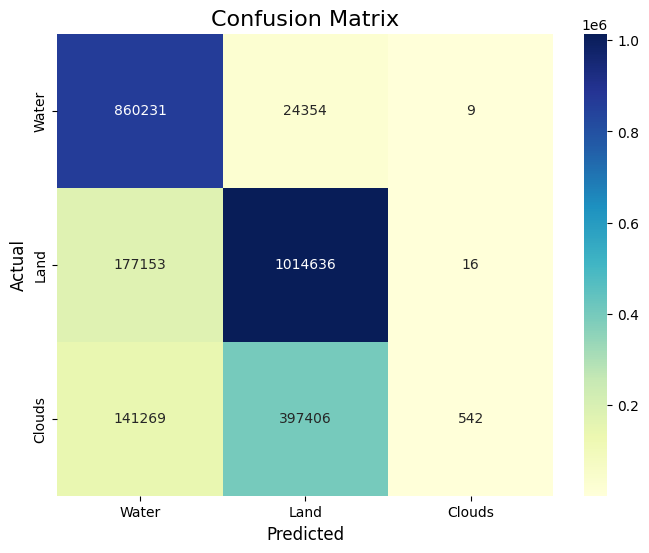

Training completed in 625.80 seconds.
Completed in 641.17 seconds.


In [ ]:
test_true_all = testing_labels.flatten()
test_pred_all = pred_map.flatten()

# Map unique class labels to indices (ensures correct ordering)
unique_classes = np.unique(test_true_all)
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}

# Remap labels to match indices
test_true_remapped = np.array([class_mapping[val] for val in test_true_all])
test_pred_remapped = np.array([class_mapping[val] for val in test_pred_all])

# Compute Confusion Matrix
cm = confusion_matrix(test_true_remapped, test_pred_remapped)

# Get class names in the correct order
class_labels = [class_names[cls] for cls in unique_classes]

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Print completion time
total_time = time.time() - start_time
print(f"Training completed in {total_training_time:.2f} seconds.")
print(f"Completed in {total_time:.2f} seconds.")